In [ ]:
import scanpy as sc
#from cellbender.remove_background.downstream import anndata_from_h5
import pandas as pd
import numpy as np
import scipy.sparse
import scipy.cluster.hierarchy as shc
from scipy import stats
from scipy.sparse import csr_matrix, hstack
import os
import anndata
import time
import SEACells
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import matplotlib.pyplot as plt
from upsetplot import plot
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['font.family'] = 'sans-serif' 

np.random.seed(1966)  # Set random seed for reproducibility

In [ ]:
# Load the normalized AnnData object for D30 non-redundant peak set
import pickle
with open('../intermediate_outputs3/sc_data/D30_nrpeakset.pickle', 'rb') as file:
    ad_norm = pickle.load(file)

In [ ]:
# Load BED files for different peak categories and create peak name lists
# Short-term memory peaks (D30 memory M12 resolved)
bed_df = pd.read_table('/data/peer/sotougl/final_outs/peak_sets/D30_memory_M12_resolved.bed',
                       sep='\t', names=['Chromosome', 'Start', 'End', 'A', 'B', 'C'], header=None)
bed_df['Start'] = bed_df['Start'] + 1
bed_df['Name'] = bed_df['Chromosome'] + ':' + bed_df['Start'].astype(str) + '-' + bed_df['End'].astype(str)
st_memory_peaks = bed_df['Name'].to_list()

# Resolved peaks (D6 induced D30 resolved)
bed_df = pd.read_table('/data/peer/sotougl/final_outs/peak_sets/D6_induced_D30_resolved.bed', sep='\t', names=['Chromosome', 'Start', 'End', 'A', 'B', 'C'], header=None)
bed_df['Start'] = bed_df['Start'] + 1
bed_df['Name'] = bed_df['Chromosome'] + ':' + bed_df['Start'].astype(str) + '-' + bed_df['End'].astype(str)
resolved_peaks = bed_df['Name'].to_list()

# Unchanged peaks (downsampled)
bed_df = pd.read_table('/data/peer/sotougl/final_outs/peak_sets/unchanged_downsampled.bed', sep='\t', names=['Chromosome', 'Start', 'End', 'A', 'B', 'C'], header=None)
bed_df['Start'] = bed_df['Start'] + 1
bed_df['Name'] = bed_df['Chromosome'] + ':' + bed_df['Start'].astype(str) + '-' + bed_df['End'].astype(str)
unchanged_peaks = bed_df['Name'].to_list()

# Long-term memory peaks (D30 M12 memory)
bed_df = pd.read_table('/data/peer/sotougl/final_outs/peak_sets/D30_M12_memory.bed', sep='\t', names=['Chromosome', 'Start', 'End', 'A', 'B', 'C'], header=None)
bed_df['Start'] = bed_df['Start'] + 1
bed_df['Name'] = bed_df['Chromosome'] + ':' + bed_df['Start'].astype(str) + '-' + bed_df['End'].astype(str)
lt_memory_peaks = bed_df['Name'].to_list()

# All memory peaks (D30 memory)
bed_df = pd.read_table('/data/peer/sotougl/final_outs/peak_sets/D30_memory.bed', sep='\t', names=['Chromosome', 'Start', 'End', 'A', 'B', 'C'], header=None)
bed_df['Start'] = bed_df['Start'] + 1
bed_df['Name'] = bed_df['Chromosome'] + ':' + bed_df['Start'].astype(str) + '-' + bed_df['End'].astype(str)
all_memory_peaks = bed_df['Name'].to_list()

In [ ]:
# Create a DataFrame to categorize peaks into different memory types
peak_info = pd.DataFrame({'Peak': ad_norm.var_names})

# Initialize columns for each peak category
peak_info['st_memory'] = 'No'
peak_info['lt_memory'] = 'No'
peak_info['resolved'] = 'No'
peak_info['unchanged'] = 'No'
peak_info['all_memory'] = 'No'

# Assign peaks to categories based on BED file lists
peak_info.loc[peak_info['Peak'].isin(st_memory_peaks), 'st_memory'] = 'Yes'
peak_info.loc[peak_info['Peak'].isin(resolved_peaks), 'resolved'] = 'Yes'
peak_info.loc[peak_info['Peak'].isin(unchanged_peaks), 'unchanged'] = 'Yes'
peak_info.loc[peak_info['Peak'].isin(lt_memory_peaks), 'lt_memory'] = 'Yes'
peak_info.loc[peak_info['Peak'].isin(all_memory_peaks), 'all_memory'] = 'Yes'

# Function to determine the primary category for each peak
def determine_category(row):
    if row['st_memory'] == 'Yes':
        return 'st_memory'
    elif row['resolved'] == 'Yes':
        return 'resolved'
    elif row['unchanged'] == 'Yes':
        return 'unchanged'
    elif row['lt_memory'] == 'Yes':
        return 'lt_memory'
    elif row['all_memory'] == 'Yes':
        return 'all_memory'
    else:
        return 'None'

peak_info['category'] = peak_info.apply(determine_category, axis=1)

peak_info

,Peak,st_memory,lt_memory,resolved,unchanged,all_memory,category
0,chr1:3398914-3399468,No,No,No,No,No,None
1,chr1:3399887-3400441,No,No,No,No,No,None
2,chr1:3611111-3611673,No,No,No,No,No,None
3,chr1:3669622-3669927,No,No,No,No,No,None
4,chr1:3670480-3672669,No,No,No,No,No,None
...,...,...,...,...,...,...,...
220879,chrX:170004195-170004751,No,No,No,No,No,None
220880,chrX:170004822-170005868,No,No,No,No,No,None
220881,chrX:170673318-170673882,No,No,No,No,No,None
220882,chrX:170674214-170677855,No,No,No,No,No,None


In [ ]:
# Add memory peak type information to the normalized AnnData object
# Calculate mean signal for each peak type across cells
peak_types = ['st_memory', 'lt_memory', 'resolved', 'unchanged', 'all_memory']
for peak_type in peak_types:
    ad_norm.obs[peak_type] = ad_norm.X[:, peak_info[peak_info[peak_type] == 'Yes'].index].mean(axis=1)

ad_norm

AnnData object with n_obs × n_vars = 143 × 220884
    obs: 'n_counts', 'Condition', 'n_peaks_detected', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'nMonoFrags', 'nDiFrags', 'nMultiFrags', 'nFrags', 'ReadsInPeaks', 'FRIP', 'Size', 'FragmentsPerSize', 'leiden', 'celltype', 'condition_celltype', 'Krt5', 'Krt14', 'Krt1', 'Krt10', 'Sox9', 'glambda_1', 'cutoff_1', 'cutoff_2', 'cutoff_3', 'glambda_1', 'cutoff_1', 'cutoff_2', 'cutoff_3', 'st_memory', 'lt_memory', 'resolved', 'unchanged', 'all_memory'
    uns: 'Condition_colors', 'log1p', 'neighbors', 'condition_celltype_colors', 'celltype_colors'
    obsm: 'X_svd', 'X_umap', 'GeneScores'
    layers: 'raw', 'OpenPeaks', 'OpenPeaks_1', 'OpenPeaks_2', 'OpenPeaks_3'
    obsp: 'distances', 'connectivities'

In [ ]:
import re
# Create a copy of the normalized AnnData object and convert to raw counts for RPKM calculation
adata_raw = ad_norm.copy()
adata_raw.X = adata_raw.layers['raw'].todense()  # Set the raw counts as the main data matrix
adata_raw.obs['n_counts'] = ad_scpeakset.obs['n_counts']  # Assign total counts to the AnnData object

# Extract the raw counts matrix and peak names
raw_counts = adata_raw.X  # Raw count matrix (cells x peaks)
peak_names = adata_raw.var_names  # Names of the peaks
n_counts = adata_raw.obs['n_counts'].values  # Total counts per SEACell

# Calculate the width of each peak from the peak name
def calculate_width(peak):
    match = re.match(r".*:(\d+)-(\d+)", peak)
    if match:
        start, end = map(int, match.groups())
        return end - start
    else:
        raise ValueError(f"Unrecognized peak format: {peak}")

peak_widths = np.array([calculate_width(peak) for peak in peak_names])  # Width of each peak

# Convert raw counts to RPKM (Reads Per Kilobase Million)
# RPKM = (1e9 * raw_count) / (n_counts * peak_width)
denominator = (n_counts[:, None] * peak_widths[None, :])  # Broadcasting for matrix division
rpkm = (1e9 * raw_counts) / denominator

# Create a new AnnData object with the RPKM matrix
adata_rpkm = anndata.AnnData(X=rpkm, obs=adata_raw.obs, var=adata_raw.var)

# Add memory peak type information to the RPKM-normalized AnnData object
peak_types = ['st_memory', 'lt_memory', 'resolved', 'unchanged', 'all_memory']
for peak_type in peak_types:
    adata_rpkm.obs[peak_type] = adata_rpkm.X[:, peak_info[peak_info[peak_type] == 'Yes'].index].mean(axis=1)

In [ ]:
# Check the distribution of cell types and conditions
adata_rpkm.obs.groupby('celltype_condition').size()

celltype_condition
Control_DB     11
Control_UB     46
Control_uHF    15
PIMQ_DB        16
PIMQ_UB        34
PIMQ_uHF       21
dtype: int64

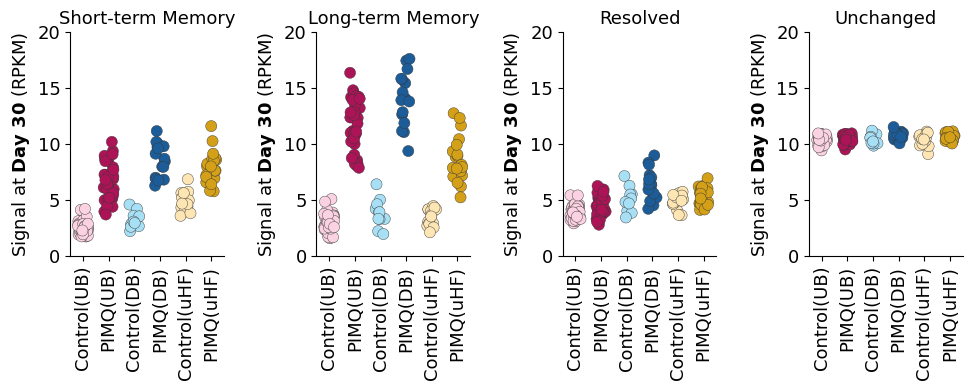

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define color palettes for different conditions (multiple definitions for different versions)
custom_palette = {
    'Control_UB': '#AED9E0',
    'PIMQ_UB': '#117A8B',
    'Control_DB': '#FFE5A8',
    'PIMQ_DB': '#FF8F00',
    'Control_uHF': '#D1B3C4',
    'PIMQ_uHF': '#673AB7'
}

custom_palette = {
    'Control_UB': '#AED9E0',
    'PIMQ_UB': '#117A8B',
    'Control_DB': '#FDE5B4',
    'PIMQ_DB': '#D4A017',
    'Control_uHF': '#D1B3C4',
    'PIMQ_uHF': '#673AB7'
}

custom_palette = {
    'Control_UB': '#AED9E0',
    'PIMQ_UB': '#117A8B',
    'Control_DB': '#85C89F',
    'PIMQ_DB': '#087A3B',
    'Control_uHF': '#FDE5B4',
    'PIMQ_uHF': '#D4A017'
}

custom_palette = {
    'Control_UB': '#FAD2E1',
    'PIMQ_UB': '#AD1457',
    'Control_DB': '#A7DFF5',
    'PIMQ_DB': '#1C5D99',
    'Control_uHF': '#FDE5B4',
    'PIMQ_uHF': '#D4A017'
}

# Create combined condition-celltype column
adata_rpkm.obs['celltype_condition'] = adata_rpkm.obs['Condition'].astype(str) + '_' + adata_rpkm.obs['celltype'].astype(str)

# Plotting parameters
font_size = 13
dot_size = 6
box_width = 0.8

# Define order for x-axis
celltype_condition_order = [
    'Control_UB', 'PIMQ_UB',
    'Control_DB', 'PIMQ_DB',
    'Control_uHF', 'PIMQ_uHF'
]

# Variables and titles for the four subplots
variables = ['st_memory', 'lt_memory', 'resolved', 'unchanged']
titles = ['Short-term Memory', 'Long-term Memory', 'Resolved', 'Unchanged']

# Create a 1x4 panel of strip plots for memory peak signals at Day 30
fig, axes = plt.subplots(1, 4, figsize=(10, 4))

for i, var in enumerate(variables):
    # Strip plot instead of box plot for better visibility of individual points
    sns.stripplot(
        data=adata_rpkm.obs,
        x='celltype_condition',
        y=var,
        palette=custom_palette,
        order=celltype_condition_order,
        size=dot_size+2,
        ax=axes[i],
        alpha=1,
        jitter=0.2,
        linewidth=0.3
    )

    axes[i].set_ylim(0, 20)
    axes[i].set_title(titles[i], fontsize=font_size)
    axes[i].set_ylabel('Signal at Day 30 (RPKM)', fontsize=font_size)
    axes[i].set_xlabel('', fontsize=font_size)
    axes[i].tick_params(axis='both', labelsize=font_size)

    # Customize x-axis labels
    axes[i].set_xticklabels(
        ['Control(UB)', 'PIMQ(UB)', 'Control(DB)', 'PIMQ(DB)', 'Control(uHF)', 'PIMQ(uHF)'],
        rotation=90,
        fontsize=font_size
    )
plt.tight_layout()
plt.savefig("../pdf_plots/D30_boxplot_bulk_memory.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Unclustered heatmaps (SEACell x memory domain)

In [ ]:
# Import libraries for heatmap analysis section
import scanpy as sc  # Single-cell analysis
import pandas as pd  # Data manipulation
import numpy as np  # Numerical computations
import scipy.sparse  # Sparse matrices
import scipy.cluster.hierarchy as shc  # Clustering
from scipy import stats  # Statistics
from scipy.sparse import csr_matrix, hstack  # Matrix operations
import os  # OS interface
import anndata  # AnnData structure
import time  # Time functions
import SEACells  # SEACell package
from matplotlib.colors import LinearSegmentedColormap  # Colormaps
import matplotlib.pyplot as plt  # Plotting
from upsetplot import plot  # UpSet plots
import seaborn as sns  # Seaborn for plots
from scipy.stats import mannwhitneyu  # Statistical tests
from scipy.stats import pearsonr, spearmanr  # Correlation
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['font.family'] = 'sans-serif'

np.random.seed(1966)

In [ ]:
# Reload the normalized AnnData object for D30
import pickle
with open('../intermediate_outputs3/sc_data/D30_nrpeakset.pickle', 'rb') as file:
    ad_norm = pickle.load(file)

In [ ]:
# Load BED files for peak categories (repeated for heatmap section)
bed_df = pd.read_table('/data/peer/sotougl/final_outs/peak_sets/D30_memory_M12_resolved.bed',
                       sep='\t', names=['Chromosome', 'Start', 'End', 'A', 'B', 'C'], header=None)
bed_df['Start'] = bed_df['Start'] + 1
bed_df['Name'] = bed_df['Chromosome'] + ':' + bed_df['Start'].astype(str) + '-' + bed_df['End'].astype(str)
st_memory_peaks = bed_df['Name'].to_list()

bed_df = pd.read_table('/data/peer/sotougl/final_outs/peak_sets/D6_induced_D30_resolved.bed', sep='\t', names=['Chromosome', 'Start', 'End', 'A', 'B', 'C'], header=None)
bed_df['Start'] = bed_df['Start'] + 1
bed_df['Name'] = bed_df['Chromosome'] + ':' + bed_df['Start'].astype(str) + '-' + bed_df['End'].astype(str)
resolved_peaks = bed_df['Name'].to_list()

bed_df = pd.read_table('/data/peer/sotougl/final_outs/peak_sets/unchanged_downsampled.bed', sep='\t', names=['Chromosome', 'Start', 'End', 'A', 'B', 'C'], header=None)
bed_df['Start'] = bed_df['Start'] + 1
bed_df['Name'] = bed_df['Chromosome'] + ':' + bed_df['Start'].astype(str) + '-' + bed_df['End'].astype(str)
unchanged_peaks = bed_df['Name'].to_list()

bed_df = pd.read_table('/data/peer/sotougl/final_outs/peak_sets/D30_M12_memory.bed', sep='\t', names=['Chromosome', 'Start', 'End', 'A', 'B', 'C'], header=None)
bed_df['Start'] = bed_df['Start'] + 1
bed_df['Name'] = bed_df['Chromosome'] + ':' + bed_df['Start'].astype(str) + '-' + bed_df['End'].astype(str)
lt_memory_peaks = bed_df['Name'].to_list()

bed_df = pd.read_table('/data/peer/sotougl/final_outs/peak_sets/D30_memory.bed', sep='\t', names=['Chromosome', 'Start', 'End', 'A', 'B', 'C'], header=None)
bed_df['Start'] = bed_df['Start'] + 1
bed_df['Name'] = bed_df['Chromosome'] + ':' + bed_df['Start'].astype(str) + '-' + bed_df['End'].astype(str)
all_memory_peaks = bed_df['Name'].to_list()

In [ ]:
# Create peak categorization DataFrame (repeated for heatmap section)
peak_info = pd.DataFrame({'Peak': ad_norm.var_names})

peak_info['st_memory'] = 'No'
peak_info['lt_memory'] = 'No'
peak_info['resolved'] = 'No'
peak_info['unchanged'] = 'No'
peak_info['all_memory'] = 'No'

peak_info.loc[peak_info['Peak'].isin(st_memory_peaks), 'st_memory'] = 'Yes'
peak_info.loc[peak_info['Peak'].isin(resolved_peaks), 'resolved'] = 'Yes'
peak_info.loc[peak_info['Peak'].isin(unchanged_peaks), 'unchanged'] = 'Yes'
peak_info.loc[peak_info['Peak'].isin(lt_memory_peaks), 'lt_memory'] = 'Yes'
peak_info.loc[peak_info['Peak'].isin(all_memory_peaks), 'all_memory'] = 'Yes'

def determine_category(row):
    if row['st_memory'] == 'Yes':
        return 'st_memory'
    elif row['resolved'] == 'Yes':
        return 'resolved'
    elif row['unchanged'] == 'Yes':
        return 'unchanged'
    elif row['lt_memory'] == 'Yes':
        return 'lt_memory'
    elif row['all_memory'] == 'Yes':
        return 'all_memory'
    else:
        return 'None'

peak_info['category'] = peak_info.apply(determine_category, axis=1)

peak_info

,Peak,st_memory,lt_memory,resolved,unchanged,all_memory,category
0,chr1:3398914-3399468,No,No,No,No,No,None
1,chr1:3399887-3400441,No,No,No,No,No,None
2,chr1:3611111-3611673,No,No,No,No,No,None
3,chr1:3669622-3669927,No,No,No,No,No,None
4,chr1:3670480-3672669,No,No,No,No,No,None
...,...,...,...,...,...,...,...
220879,chrX:170004195-170004751,No,No,No,No,No,None
220880,chrX:170004822-170005868,No,No,No,No,No,None
220881,chrX:170673318-170673882,No,No,No,No,No,None
220882,chrX:170674214-170677855,No,No,No,No,No,None


In [ ]:
# Reload normalized data (repeated)
import pickle
with open('../intermediate_outputs3/sc_data/D30_nrpeakset.pickle', 'rb') as file:
    ad_norm = pickle.load(file)

In [ ]:
# Define lists of SEACell IDs for each condition and cell type combination
d30_ctrl_ub = list(ad_norm[ad_norm.obs['condition_celltype'] == 'Control_UB'].obs_names)
d30_ctrl_db = list(ad_norm[ad_norm.obs['condition_celltype'] == 'Control_DB'].obs_names)
d30_ctrl_uhf = list(ad_norm[ad_norm.obs['condition_celltype'] == 'Control_uHF'].obs_names)
d30_pimq_ub = list(ad_norm[ad_norm.obs['condition_celltype'] == 'PIMQ_UB'].obs_names)
d30_pimq_db = list(ad_norm[ad_norm.obs['condition_celltype'] == 'PIMQ_DB'].obs_names)
d30_pimq_uhf = list(ad_norm[ad_norm.obs['condition_celltype'] == 'PIMQ_uHF'].obs_names)
print(len(d30_ctrl_ub + d30_pimq_ub),
     len(d30_ctrl_db + d30_pimq_db),
     len(d30_ctrl_uhf + d30_pimq_uhf))

80 27 36


In [ ]:
# Print the number of peaks in each memory category
peak_type = 'lt_memory'
print(len(peak_info[peak_info[peak_type] == 'Yes']['Peak']))
peak_type = 'st_memory'
print(len(peak_info[peak_info[peak_type] == 'Yes']['Peak']))
peak_type = 'resolved'
print(len(peak_info[peak_info[peak_type] == 'Yes']['Peak']))
peak_type = 'unchanged'
print(len(peak_info[peak_info[peak_type] == 'Yes']['Peak']))

117
117
933
934


In [ ]:
# Convert AnnData to DataFrame and z-score normalize for heatmap visualization
# This creates a standardized matrix where each peak has mean 0 and std 1
zscore_matrix = ad_norm.to_df()
zscore_matrix = (zscore_matrix - zscore_matrix.mean()) / zscore_matrix.std()

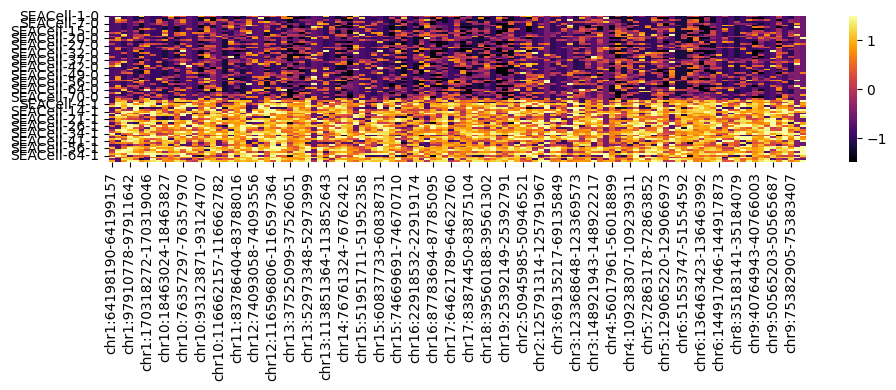

In [ ]:
# Heatmap for UB cells - Long-term memory peaks
plt.figure(figsize=(116/11.6, 76/19))  # Custom figure size based on data dimensions
peak_type = 'lt_memory'
sns.heatmap(zscore_matrix.loc[d30_ctrl_ub + d30_pimq_ub, peak_info[peak_info[peak_type] == 'Yes']['Peak'].values],
            cmap='inferno',
           vmin=-1.5,
           vmax=1.5)
plt.tight_layout()
plt.savefig("../pdf_plots/D30_heatmap_UB_LTmem.pdf", format="pdf", bbox_inches="tight")
plt.show()

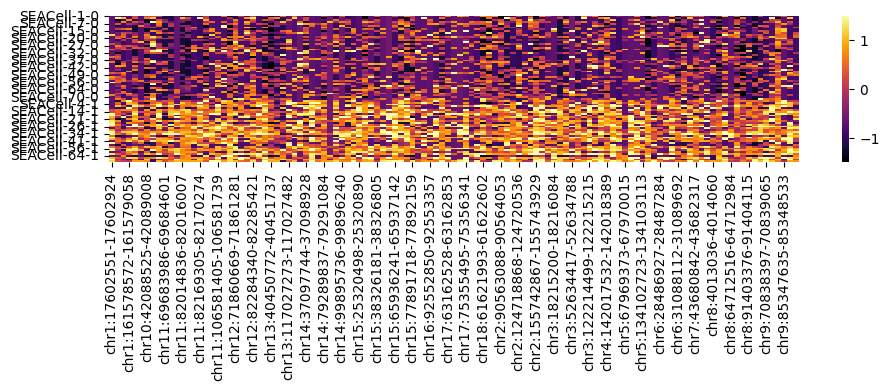

In [ ]:
# Heatmap for UB cells - Short-term memory peaks
plt.figure(figsize=(115/11.6, 76/19))
peak_type = 'st_memory'
sns.heatmap(zscore_matrix.loc[d30_ctrl_ub + d30_pimq_ub, peak_info[peak_info[peak_type] == 'Yes']['Peak'].values],
            cmap='inferno',
           vmin=-1.5,
           vmax=1.5)
plt.tight_layout()
plt.savefig("../pdf_plots/D30_heatmap_UB_STmem.pdf", format="pdf", bbox_inches="tight")
plt.show()

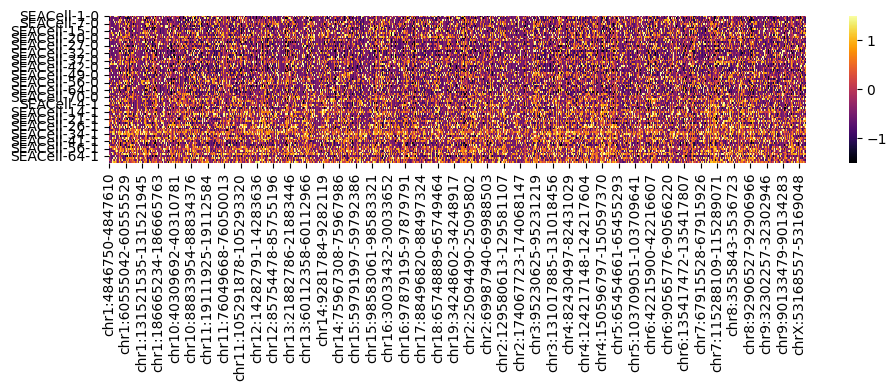

In [ ]:
# Heatmap for UB cells - Resolved peaks
plt.figure(figsize=(116/11.6, 76/19))
peak_type = 'resolved'
sns.heatmap(zscore_matrix.loc[d30_ctrl_ub + d30_pimq_ub, peak_info[peak_info[peak_type] == 'Yes']['Peak'].values],
            cmap='inferno',
           vmin=-1.5,
           vmax=1.5)
plt.tight_layout()
plt.savefig("../pdf_plots/D30_heatmap_UB_RESOLVED.pdf", format="pdf", bbox_inches="tight")
plt.show()

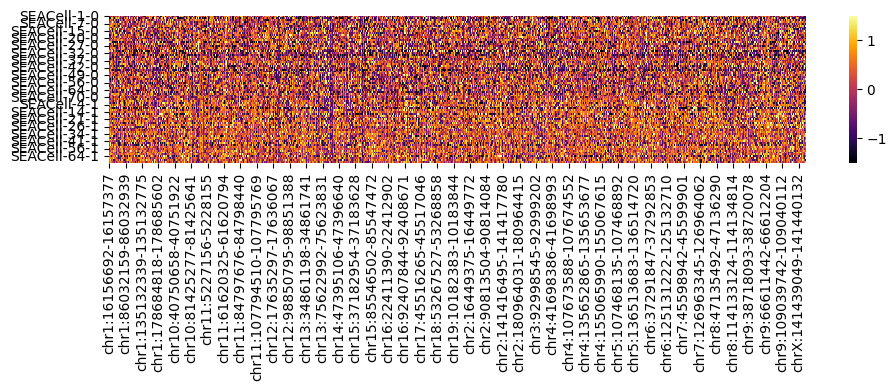

In [ ]:
# Heatmap for UB cells - Unchanged peaks
plt.figure(figsize=(116/11.6, 76/19))
peak_type = 'unchanged'
sns.heatmap(zscore_matrix.loc[d30_ctrl_ub + d30_pimq_ub, peak_info[peak_info[peak_type] == 'Yes']['Peak'].values],
            cmap='inferno',
           vmin=-1.5,
           vmax=1.5)
plt.tight_layout()
plt.savefig("../pdf_plots/D30_heatmap_UB_UNCHANGED.pdf", format="pdf", bbox_inches="tight")
plt.show()

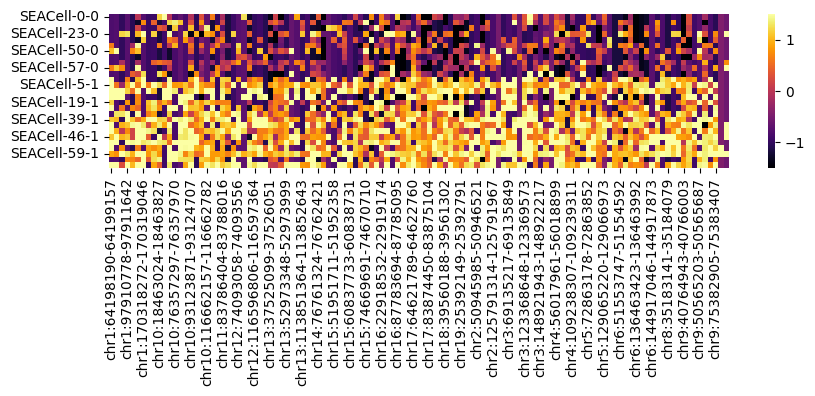

In [ ]:
# Heatmap for DB cells - Long-term memory peaks
plt.figure(figsize=(116/11.6, 38/19))
peak_type = 'lt_memory'
sns.heatmap(zscore_matrix.loc[d30_ctrl_db + d30_pimq_db, peak_info[peak_info[peak_type] == 'Yes']['Peak'].values],
            cmap='inferno',
           vmin=-1.5,
           vmax=1.5)
plt.tight_layout()
plt.savefig("../pdf_plots/D30_heatmap_DB_LTmem.pdf", format="pdf", bbox_inches="tight")
plt.show()

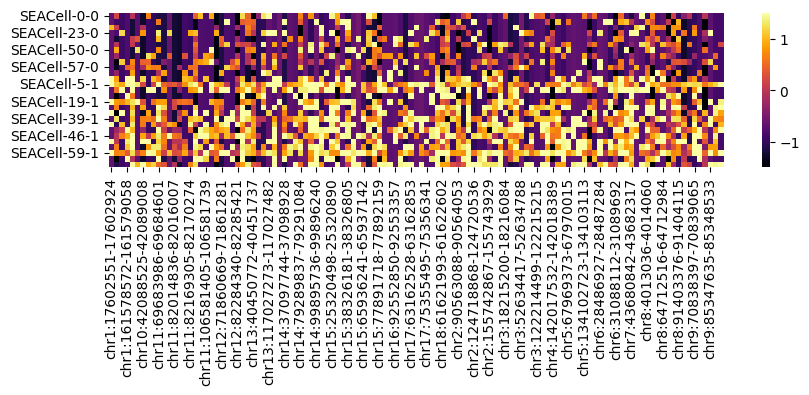

In [ ]:
# Heatmap for DB cells - Short-term memory peaks
plt.figure(figsize=(115/11.6, 38/19))
peak_type = 'st_memory'
sns.heatmap(zscore_matrix.loc[d30_ctrl_db + d30_pimq_db, peak_info[peak_info[peak_type] == 'Yes']['Peak'].values],
            cmap='inferno',
           vmin=-1.5,
           vmax=1.5)
plt.tight_layout()
plt.savefig("../pdf_plots/D30_heatmap_DB_STmem.pdf", format="pdf", bbox_inches="tight")
plt.show()

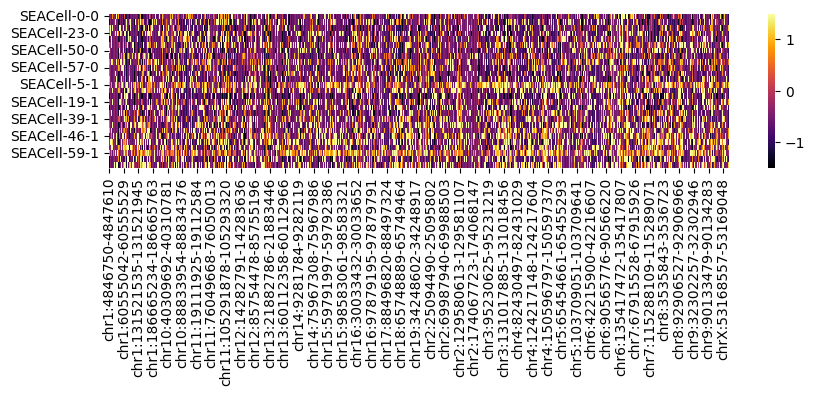

In [ ]:
# Heatmap for DB cells - Resolved peaks
plt.figure(figsize=(116/11.6, 38/19))
peak_type = 'resolved'
sns.heatmap(zscore_matrix.loc[d30_ctrl_db + d30_pimq_db, peak_info[peak_info[peak_type] == 'Yes']['Peak'].values],
            cmap='inferno',
           vmin=-1.5,
           vmax=1.5)
plt.tight_layout()
plt.savefig("../pdf_plots/D30_heatmap_DB_RESOLVED.pdf", format="pdf", bbox_inches="tight")
plt.show()

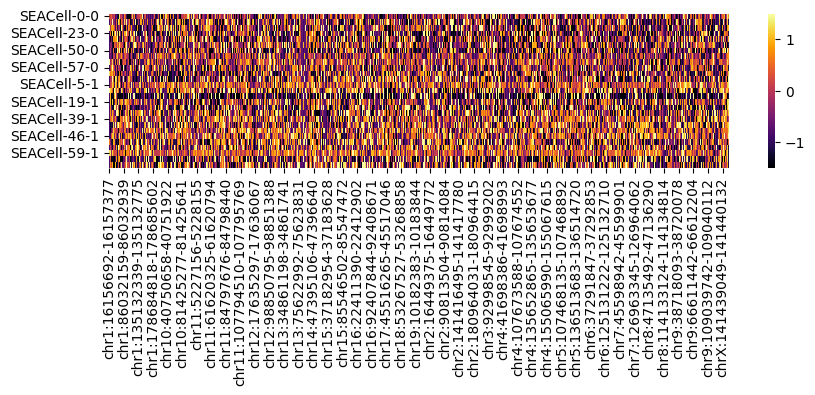

In [ ]:
# Heatmap for DB cells - Unchanged peaks
plt.figure(figsize=(116/11.6, 38/19))
peak_type = 'unchanged'
sns.heatmap(zscore_matrix.loc[d30_ctrl_db + d30_pimq_db, peak_info[peak_info[peak_type] == 'Yes']['Peak'].values],
            cmap='inferno',
           vmin=-1.5,
           vmax=1.5)
plt.tight_layout()
plt.savefig("../pdf_plots/D30_heatmap_DB_UNCHANGED.pdf", format="pdf", bbox_inches="tight")
plt.show()

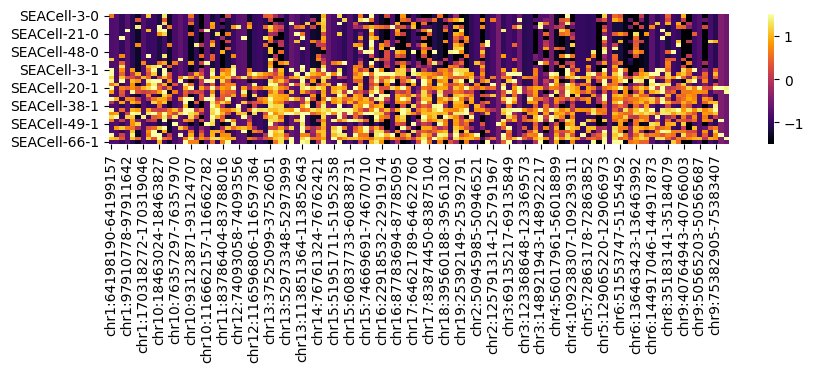

In [ ]:
# Heatmap for UHF cells - Long-term memory peaks
plt.figure(figsize=(116/11.6, 32/19))
peak_type = 'lt_memory'
sns.heatmap(zscore_matrix.loc[d30_ctrl_uhf + d30_pimq_uhf, peak_info[peak_info[peak_type] == 'Yes']['Peak'].values],
            cmap='inferno',
           vmin=-1.5,
           vmax=1.5)
plt.tight_layout()
plt.savefig("../pdf_plots/D30_heatmap_UHF_LTmem.pdf", format="pdf", bbox_inches="tight")
plt.show()

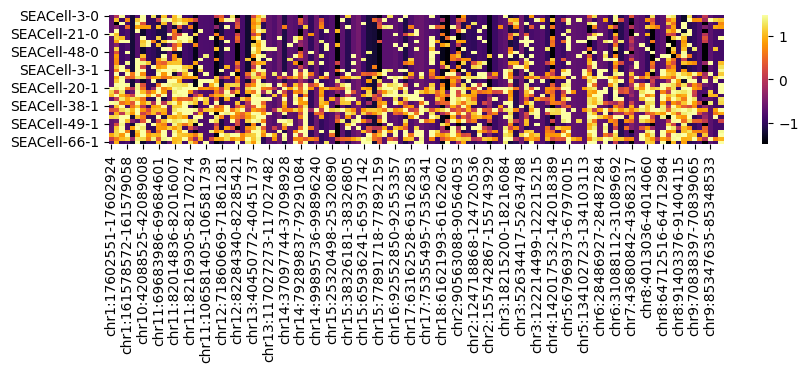

In [ ]:
# Heatmap for UHF cells - Short-term memory peaks
plt.figure(figsize=(115/11.6, 32/19))
peak_type = 'st_memory'
sns.heatmap(zscore_matrix.loc[d30_ctrl_uhf + d30_pimq_uhf, peak_info[peak_info[peak_type] == 'Yes']['Peak'].values],
            cmap='inferno',
           vmin=-1.5,
           vmax=1.5)
plt.tight_layout()
plt.savefig("../pdf_plots/D30_heatmap_UHF_STmem.pdf", format="pdf", bbox_inches="tight")
plt.show()

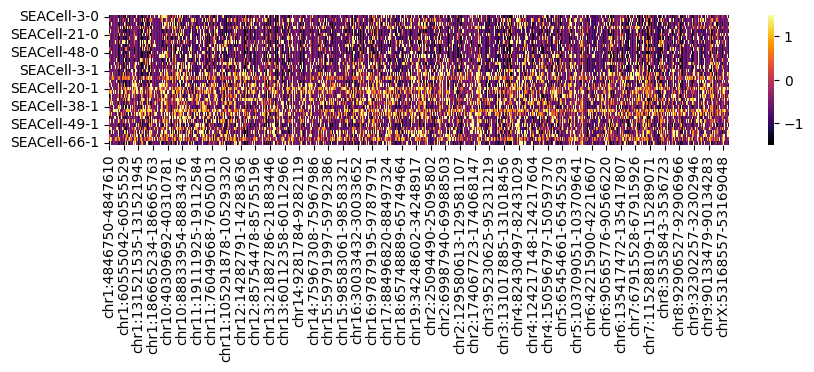

In [ ]:
# Heatmap for UHF cells - Resolved peaks
plt.figure(figsize=(116/11.6, 32/19))
peak_type = 'resolved'
sns.heatmap(zscore_matrix.loc[d30_ctrl_uhf + d30_pimq_uhf, peak_info[peak_info[peak_type] == 'Yes']['Peak'].values],
            cmap='inferno',
           vmin=-1.5,
           vmax=1.5)
plt.tight_layout()
plt.savefig("../pdf_plots/D30_heatmap_UHF_RESOLVED.pdf", format="pdf", bbox_inches="tight")
plt.show()

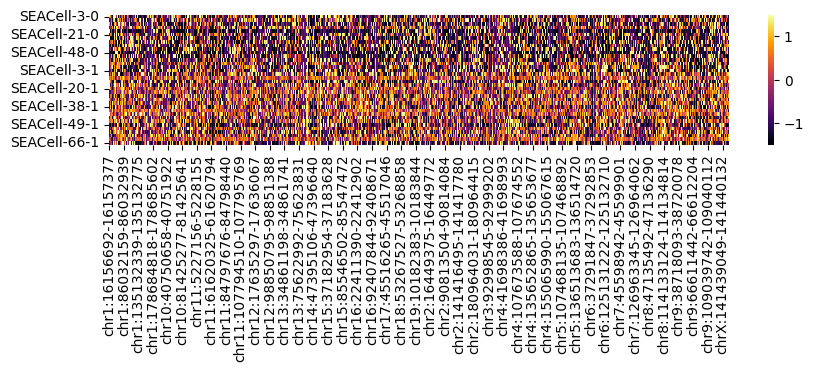

In [ ]:
# Heatmap for UHF cells - Unchanged peaks
plt.figure(figsize=(116/11.6, 32/19))
peak_type = 'unchanged'
sns.heatmap(zscore_matrix.loc[d30_ctrl_uhf + d30_pimq_uhf, peak_info[peak_info[peak_type] == 'Yes']['Peak'].values],
            cmap='inferno',
           vmin=-1.5,
           vmax=1.5)
plt.tight_layout()
plt.savefig("../pdf_plots/D30_heatmap_UHF_UNCHANGED.pdf", format="pdf", bbox_inches="tight")
plt.show()

# FDL embedding plots

# D30 embedding plot

In [ ]:
# Load normalized data for D30 embedding analysis
import pickle
import scanpy as sc
with open('../intermediate_outputs3/sc_data/D30_nrpeakset.pickle', 'rb') as file:
    ad_norm = pickle.load(file)

In [ ]:
# Set timepoint and input directories for D30
timepoint = 'D30'
sample_type = 'D30'

input_dir = '../intermediate_outputs3/projects/ArchR_D30_min_NA_max_600_scpeakset/'
data_dir = input_dir + 'seacells/SEACells_export/'

In [ ]:
# Load control and PIMQ SEACell data for D30 and concatenate
ad_control = sc.read(input_dir + 'seacells/' + timepoint + '_Control.h5ad')
ad_pimq = sc.read(input_dir + 'seacells/' + timepoint + '_PIMQ.h5ad')
ad2 = anndata.concat([ad_control, ad_pimq])

In [ ]:
# Merge celltype and condition_celltype information from normalized data
ad2.obs = pd.merge(ad2.obs, ad_norm.obs[['celltype', 'condition_celltype']], left_on='SEACell', right_index=True)

In [ ]:
# Import libraries for trajectory analysis
#import harmony  # Batch correction (commented out)
import palantir  # Trajectory inference

In [ ]:
# Define color palette for condition-celltype combinations
palette1 = {
    'Control_UB': '#AED9E0',
    'PIMQ_UB': '#117A8B',
    'Control_DB': '#85C89F',
    'PIMQ_DB': '#087A3B',
    'Control_uHF': '#FDE5B4',
    'PIMQ_uHF': '#D4A017'
}

In [ ]:
# Compute neighbors for graph construction
sc.pp.neighbors(ad2, use_rep='X_svd')

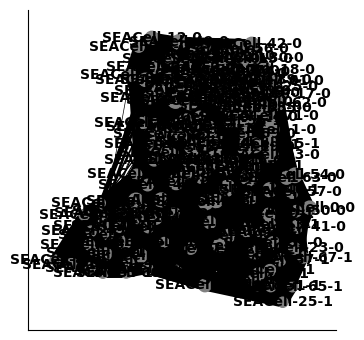

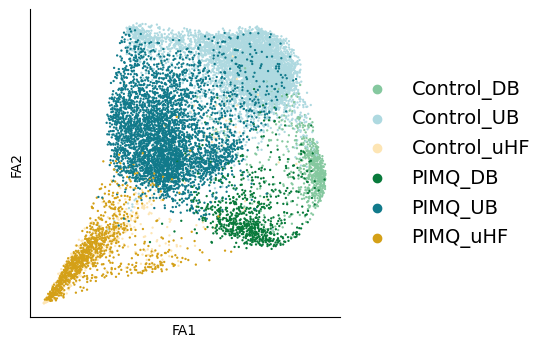

In [ ]:
# Compute PAGA and draw graph with force-directed layout
sc.tl.paga(ad2, groups='SEACell')
sc.pl.paga(ad2)
sc.tl.draw_graph(ad2, layout='fa', init_pos='paga')
sc.pl.draw_graph(ad2, color=['condition_celltype'], legend_fontsize=14, palette=palette1, title='')

In [ ]:
# Save single-cell observations to CSV
ad2.obs.to_csv('../intermediate_outputs3/D30_singlecell_obs.csv')

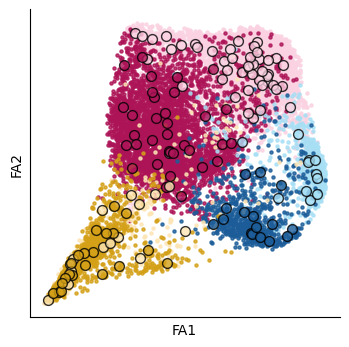

In [ ]:
# Extract force-directed layout coordinates for single cells
coordinates = ad2.obsm['X_draw_graph_fa']
data = ad2.obs[['condition_celltype']]

# Define color palette (overriding previous)
palette = {
    'Control_UB': '#AED9E0',
    'PIMQ_UB': '#117A8B',
    'Control_DB': '#85C89F',
    'PIMQ_DB': '#087A3B',
    'Control_uHF': '#FDE5B4',
    'PIMQ_uHF': '#D4A017'
}

palette = {
    'Control_UB': '#FAD2E1',
    'PIMQ_UB': '#AD1457',
    'Control_DB': '#A7DFF5',
    'PIMQ_DB': '#1C5D99',
    'Control_uHF': '#FDE5B4',
    'PIMQ_uHF': '#D4A017'
}

plt.figure(figsize=(4, 4))

# Plot single-cell points
for group, color in palette.items():
    group_indices = data["condition_celltype"] == group
    x = coordinates[group_indices, 0]  # FA1
    y = coordinates[group_indices, 1]  # FA2
    plt.scatter(
        x,
        y,
        label=group,
        edgecolors=color,
        s=5,
        facecolors=color,
        alpha=0.8
    )
    plt.xticks([])
    plt.yticks([])

    # Add axis labels
    plt.xlabel("FA1")
    plt.ylabel("FA2")

# Group coordinates by SEACell and calculate mean positions
from collections import defaultdict

seacell_ids = np.array(ad2.obs['SEACell'].values)
umap_coordinates = ad2.obsm['X_draw_graph_fa']

grouped_coords = defaultdict(list)
for seacell_id, coord in zip(seacell_ids, umap_coordinates):
    grouped_coords[seacell_id].append(coord)

# Calculate mean coordinates for each SEACell
unique_seacell_ids = sorted(grouped_coords.keys())
mean_umap_coordinates = np.array([np.mean(grouped_coords[seacell_id], axis=0) for seacell_id in unique_seacell_ids])
mean_umap_df = pd.DataFrame(mean_umap_coordinates, 
                            index=unique_seacell_ids, 
                            columns=["FA_1", "FA_2"])

# Plot SEACell mean positions on top
coordinates = mean_umap_df.loc[ad_norm.obs_names].values
data = ad_norm.obs[['condition_celltype']]

for group, color in palette.items():
    group_indices = data["condition_celltype"] == group
    x = coordinates[group_indices, 0]
    y = coordinates[group_indices, 1]
    plt.scatter(
        x,
        y,
        label=group,
        edgecolors="black",
        s=50,
        facecolors=color,
        alpha=0.8
    )
    plt.xticks([])
    plt.yticks([])

    plt.xlabel("FA1")
    plt.ylabel("FA2")
    
# Save the combined single-cell and SEACell embedding plot
plt.savefig("../pdf_plots/D30_FDL_seacells_singlecell.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

# Year 1 UMAP

In [ ]:
# Set parameters for Year 1 analysis
timepoint = 'Y1'
sample_type = 'Y1'

input_dir = '../intermediate_outputs3/projects/ArchR_Y1_min_NA_max_600_scpeakset/'
data_dir = input_dir + 'seacells/SEACells_export/'

In [ ]:
# Load Year 1 control and PIMQ SEACell data
ad_control = sc.read(input_dir + 'seacells/' + timepoint + '_Control.h5ad')
ad_pimq = sc.read(input_dir + 'seacells/' + timepoint + '_PIMQ.h5ad')
ad2 = anndata.concat([ad_control, ad_pimq])

In [ ]:
# Load Year 1 normalized data
import pickle
with open('../intermediate_outputs3/sc_data/Y1_nrpeakset.pickle', 'rb') as file:
    ad_norm = pickle.load(file)

In [ ]:
# Merge metadata for Year 1
ad2.obs = pd.merge(ad2.obs, ad_norm.obs[['celltype', 'condition_celltype']], left_on='SEACell', right_index=True)

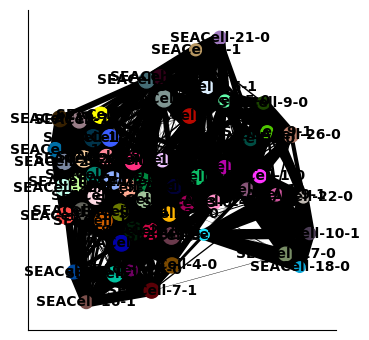

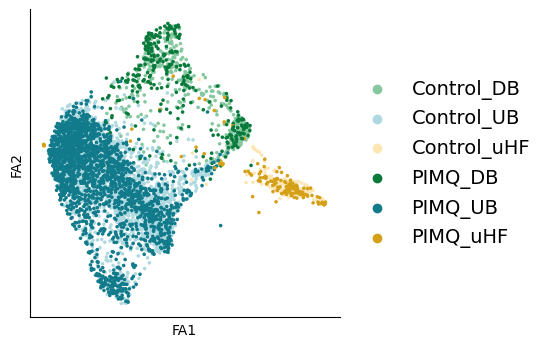

In [ ]:
# Compute PAGA and draw graph for Year 1
sc.tl.paga(ad2, groups='SEACell')
sc.pl.paga(ad2)
sc.tl.draw_graph(ad2, layout='fa', init_pos='paga')
sc.pl.draw_graph(ad2, color=['condition_celltype'], legend_fontsize=14, palette=palette1, title='')

In [ ]:
# Save Year 1 single-cell observations
ad2.obs.to_csv('../intermediate_outputs3/Y1_singlecell_obs.csv')

In [ ]:
# Reload Year 1 normalized data
import pickle
with open('../intermediate_outputs3/sc_data/Y1_nrpeakset.pickle', 'rb') as file:
    ad_norm = pickle.load(file)

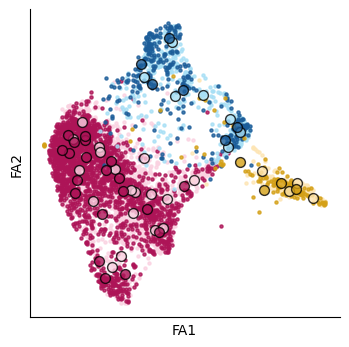

In [ ]:
# Extract coordinates for Year 1 single cells
coordinates = ad2.obsm['X_draw_graph_fa']
data = ad2.obs[['condition_celltype']]

# Define palette for Year 1 (similar to D30)
palette = {
    'Control_UB': '#AED9E0',
    'PIMQ_UB': '#117A8B',
    'Control_DB': '#85C89F',
    'PIMQ_DB': '#087A3B',
    'Control_uHF': '#FDE5B4',
    'PIMQ_uHF': '#D4A017'
}
palette = {
    'Control_UB': '#FAD2E1',
    'PIMQ_UB': '#AD1457',
    'Control_DB': '#A7DFF5',
    'PIMQ_DB': '#1C5D99',
    'Control_uHF': '#FDE5B4',
    'PIMQ_uHF': '#D4A017'
}

plt.figure(figsize=(4, 4))

# Plot Year 1 single-cell points
for group, color in palette.items():
    group_indices = data["condition_celltype"] == group
    x = coordinates[group_indices, 0]
    y = coordinates[group_indices, 1]
    plt.scatter(
        x,
        y,
        label=group,
        edgecolors=color,
        s=5,
        facecolors=color,
        alpha=0.8
    )
    plt.xticks([])
    plt.yticks([])

    plt.xlabel("FA1")
    plt.ylabel("FA2")

# Group and calculate mean SEACell positions for Year 1
from collections import defaultdict

seacell_ids = np.array(ad2.obs['SEACell'].values)
umap_coordinates = ad2.obsm['X_draw_graph_fa']

grouped_coords = defaultdict(list)
for seacell_id, coord in zip(seacell_ids, umap_coordinates):
    grouped_coords[seacell_id].append(coord)

unique_seacell_ids = sorted(grouped_coords.keys())
mean_umap_coordinates = np.array([np.mean(grouped_coords[seacell_id], axis=0) for seacell_id in unique_seacell_ids])
mean_umap_df = pd.DataFrame(mean_umap_coordinates, 
                            index=unique_seacell_ids, 
                            columns=["FA_1", "FA_2"])

# Plot SEACell means for Year 1
coordinates = mean_umap_df.loc[ad_norm.obs_names].values
data = ad_norm.obs[['condition_celltype']]

palette = {
    'Control_UB': '#FAD2E1',
    'PIMQ_UB': '#AD1457',
    'Control_DB': '#A7DFF5',
    'PIMQ_DB': '#1C5D99',
    'Control_uHF': '#FDE5B4',
    'PIMQ_uHF': '#D4A017'
}

for group, color in palette.items():
    group_indices = data["condition_celltype"] == group
    x = coordinates[group_indices, 0]
    y = coordinates[group_indices, 1]
    plt.scatter(
        x,
        y,
        label=group,
        edgecolors="black",
        s=50,
        facecolors=color,
        alpha=0.8
    )
    plt.xticks([])
    plt.yticks([])

    plt.xlabel("FA1")
    plt.ylabel("FA2")
    
# Save Year 1 embedding plot
plt.savefig("../pdf_plots/Y1_FDL_seacells_singlecell.png", format="png", dpi=300, bbox_inches="tight")
plt.show()